In [91]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [92]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


In [93]:
train_path = "./train_tracked_agent"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
with open(train_pkl_lst[1], 'rb') as f:
    training_sample = pickle.load(f)

# LSTM

In [94]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        #print(x.size())
        #print(x.size(-1))
        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, h_t
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0

# Dataset

In [95]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices, interval, window_size):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.interval = interval
        self.window_size = window_size
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
#         # the index of agent to be predicted 
#         pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
#         # input: p_in & v_in; output: p_out
#         inp_scene = np.dstack([scene['p_in']])
#         out_scene = np.dstack([scene['p_out']])
        
#         # Normalization 
#         min_vecs = np.min(inp_scene, axis = (0,1))
#         max_vecs = np.max(inp_scene, axis = (0,1))
        
#         # Normalize by vectors
#         inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
#         out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
#         print("Input shape: " + str(scene['inp'].shape)) #(19,4)
#         print("Output shape: " + str(scene['out'].shape)) #(30,4)
        inp = scene['inp'][:,:2]
        out = scene['out'][:,:2]
        
        dat = np.concatenate((inp, out), axis=0)
        
        train_data = []
#         window_size = 20
#         interval = 1
        for i in range(0, len(dat), self.interval):
            #print(len(dat[i:i+input_length]))
            if i + self.window_size < len(dat): 
                train_data.append(dat[i:i+self.window_size])
            
        #print(len(train_data))
        #print(train_data)
        
        input_seq = []
        target_seq = []
        for i in range(len(train_data)):
            input_seq.append(train_data[i][:-1])
            target_seq.append(train_data[i][1:])
            
        input_seq = np.array(input_seq, dtype=np.float32)
        target_seq = np.array(target_seq, dtype=np.float32)
        
        #print(input_seq)
        #print(input_seq.shape)
        #print(target_seq.shape)
        
        return torch.from_numpy(input_seq).float(), torch.from_numpy(target_seq).float()

# Hyperparameter

In [96]:
# Grid/Random Search

In [97]:
# batch_size = 64
interval = 1 # sampling interval for LSTM
window_size = 20 # number of timesteps to take as input
batch_size = 512
#in_dim = 19*4 # MLP
#out_dim = 4 #30*2 # MLP
input_size = 2 # LSTM
output_size = 2 # LSTM (has to match input_size)
hidden_dim = 60 #32 #128
num_layers = 2 #3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [98]:
train_path = "./train_tracked_agent"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices, interval, window_size)
valid_set = ArgoverseDataset(train_path, valid_indices, interval, window_size)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

# Model, Loss Function and Optimizer

In [99]:
model = MyLSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=num_layers).to(device)

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

# Training

In [100]:
for inp, tgt in train_loader:
    print(inp.shape)
    print(tgt.shape)
    print(inp.view(-1, window_size-1, 4).size()) 
    print(inp[0, 0, :, :])
    break
        

torch.Size([512, 29, 19, 2])
torch.Size([512, 29, 19, 2])
torch.Size([7424, 19, 4])
tensor([[1.0000, 1.0000],
        [0.9996, 0.9995],
        [0.9994, 0.9990],
        [0.9990, 0.9984],
        [0.9987, 0.9981],
        [0.9983, 0.9975],
        [0.9980, 0.9969],
        [0.9976, 0.9963],
        [0.9975, 0.9960],
        [0.9971, 0.9952],
        [0.9970, 0.9949],
        [0.9965, 0.9942],
        [0.9961, 0.9935],
        [0.9958, 0.9929],
        [0.9955, 0.9924],
        [0.9952, 0.9919],
        [0.9949, 0.9915],
        [0.9946, 0.9910],
        [0.9941, 0.9902]])


In [101]:
def train_epoch(train_loader, model, optimizer, loss_function):

    train_mse = []
    for inp, tgt in tqdm(train_loader):
        
        inp = inp.view(-1, window_size-1, 2)
        tgt = tgt.view(-1, window_size-1, 2)
        
        #print(inp.size())
        
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        output, hidden = model(inp)
        output = output.to(device)
        #print(output.shape)
        #print(hidden.shape)
        #print(tgt.view(-1, 4).size())
        
        loss = loss_function(output, tgt.view(-1, 2))
        train_mse.append(loss.item()) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    
    valid_mse = []
    #preds = []
    #trues = []
    
    with torch.no_grad():
        for inp, tgt in valid_loader:
            
            inp = inp.view(-1, window_size-1, 2)
            tgt = tgt.view(-1, window_size-1, 2)
            
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            output, hidden = model(inp)
            output = output.to(device)
                    
            loss = loss_function(output, tgt.view(-1, 2))
            valid_mse.append(loss.item())
            
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse#, preds, trues


In [102]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

In [103]:
len(train_pkl_lst)

205943

In [104]:
model.load_state_dict(torch.load('Current_LstmPositionsOnly_hdim_128_wsize_20_interval_1_nlayers_2_bs_512_lr_0.01_decay_0.95.pt'))

RuntimeError: Error(s) in loading state_dict for MyLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 2]) from checkpoint, the shape in current model is torch.Size([240, 2]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([240, 60]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for lstm.weight_ih_l1: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([240, 60]).
	size mismatch for lstm.weight_hh_l1: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([240, 60]).
	size mismatch for lstm.bias_ih_l1: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for lstm.bias_hh_l1: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 128]) from checkpoint, the shape in current model is torch.Size([2, 60]).

 88%|████████▊ | 309/352 [03:37<00:22,  1.89it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.09661]
0.04169
Epoch 1 | T: 4.70 | Train RMSE: 0.09661 | Valid RMSE: 0.04169


/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


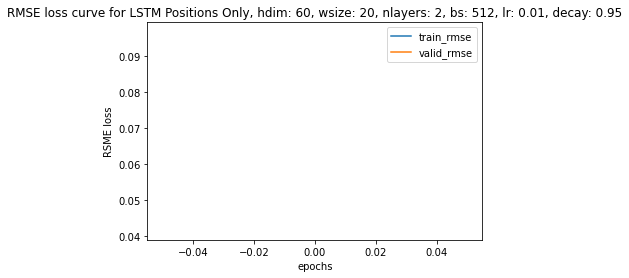

 88%|████████▊ | 308/352 [03:46<00:40,  1.09it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.09661, 0.02828]
0.01568
Epoch 2 | T: 5.02 | Train RMSE: 0.02828 | Valid RMSE: 0.01568


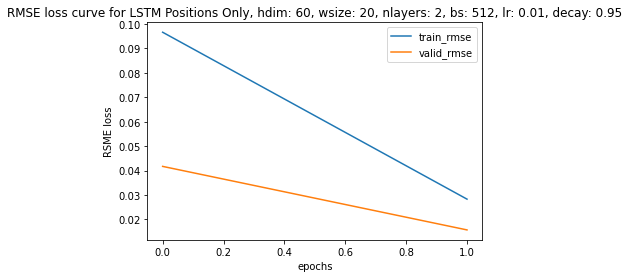

 88%|████████▊ | 308/352 [03:43<04:21,  5.94s/it]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.09661, 0.02828, 0.01518]
0.01398
Epoch 3 | T: 4.83 | Train RMSE: 0.01518 | Valid RMSE: 0.01398


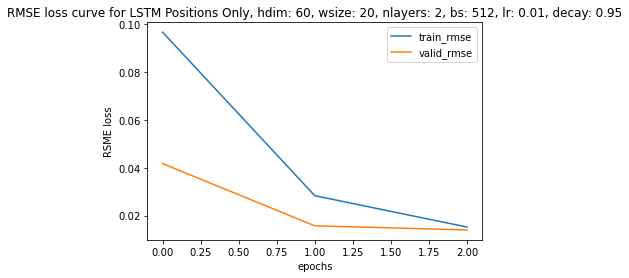

 88%|████████▊ | 308/352 [03:25<00:25,  1.71it/s]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.09661, 0.02828, 0.01518, 0.01411]
0.01279
Epoch 4 | T: 4.87 | Train RMSE: 0.01411 | Valid RMSE: 0.01279


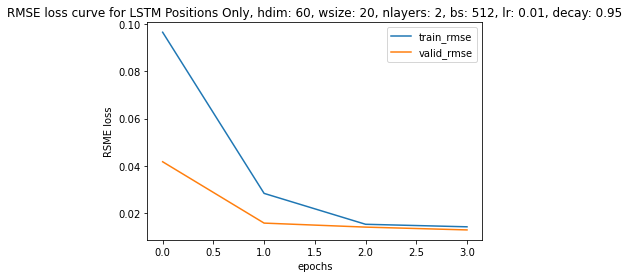

 88%|████████▊ | 308/352 [03:27<00:20,  2.15it/s]


100%|██████████| 352/352 [04:14<00:00,  1.38it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321]
0.00948
Epoch 5 | T: 4.73 | Train RMSE: 0.01321 | Valid RMSE: 0.00948


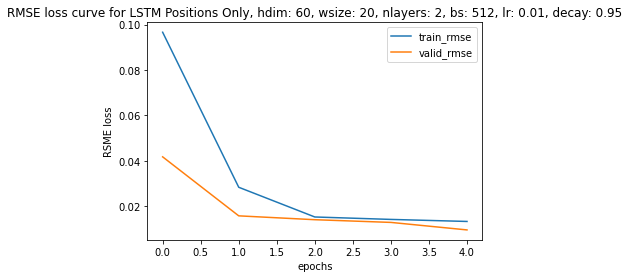

 88%|████████▊ | 308/352 [03:39<00:25,  1.74it/s]


100%|██████████| 352/352 [04:24<00:00,  1.33it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294]
0.01077
Epoch 6 | T: 4.85 | Train RMSE: 0.01294 | Valid RMSE: 0.01077


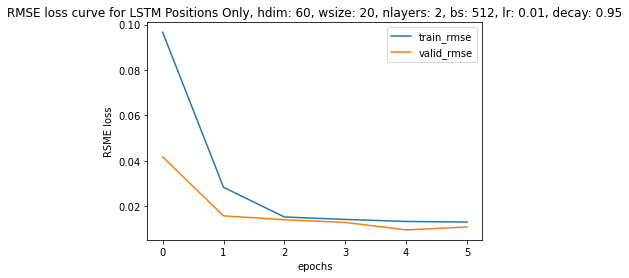

 88%|████████▊ | 308/352 [03:45<00:23,  1.88it/s]


100%|██████████| 352/352 [04:10<00:00,  1.41it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303]
0.01053
Epoch 7 | T: 4.98 | Train RMSE: 0.01303 | Valid RMSE: 0.01053


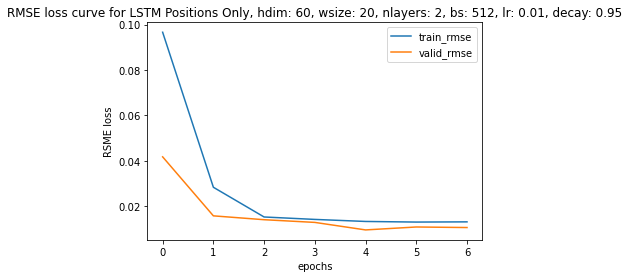

 88%|████████▊ | 308/352 [03:47<00:25,  1.76it/s]


100%|██████████| 352/352 [04:12<00:00,  1.40it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108]
0.00798
Epoch 8 | T: 5.08 | Train RMSE: 0.01108 | Valid RMSE: 0.00798


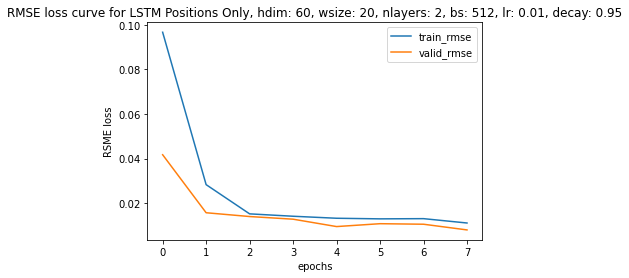

 88%|████████▊ | 308/352 [03:44<00:26,  1.68it/s]


100%|██████████| 352/352 [04:27<00:00,  1.32it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931]
0.00573
Epoch 9 | T: 4.93 | Train RMSE: 0.00931 | Valid RMSE: 0.00573


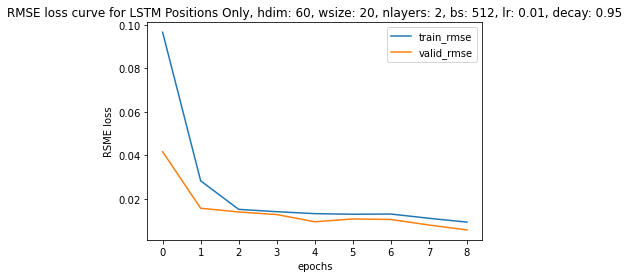

 88%|████████▊ | 308/352 [03:43<00:25,  1.75it/s]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432]
0.00266
Epoch 10 | T: 4.96 | Train RMSE: 0.00432 | Valid RMSE: 0.00266


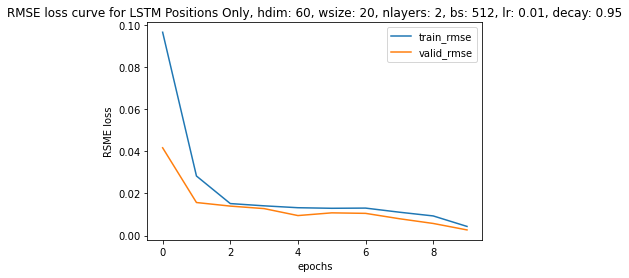

 88%|████████▊ | 308/352 [03:43<00:35,  1.23it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428]
0.00349
Epoch 11 | T: 4.99 | Train RMSE: 0.00428 | Valid RMSE: 0.00349


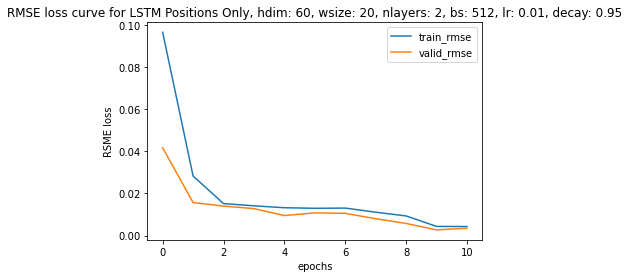

 88%|████████▊ | 308/352 [03:44<00:21,  2.02it/s]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481]
0.005
Epoch 12 | T: 4.92 | Train RMSE: 0.00481 | Valid RMSE: 0.00500


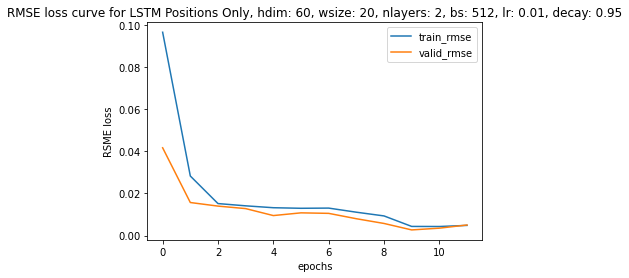

 88%|████████▊ | 308/352 [03:48<00:25,  1.74it/s]


100%|██████████| 352/352 [04:12<00:00,  1.39it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481, 0.0037]
0.00268
Epoch 13 | T: 5.04 | Train RMSE: 0.00370 | Valid RMSE: 0.00268


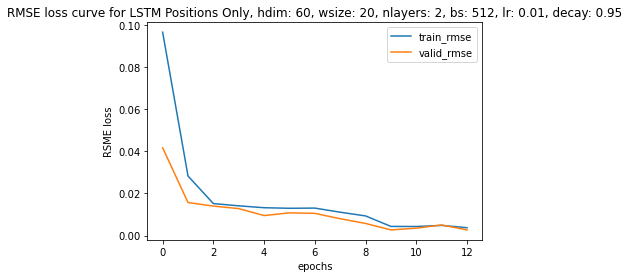

 88%|████████▊ | 308/352 [03:42<00:26,  1.64it/s]


100%|██████████| 352/352 [04:08<00:00,  1.42it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481, 0.0037, 0.00379]
0.00307
Epoch 14 | T: 4.91 | Train RMSE: 0.00379 | Valid RMSE: 0.00307


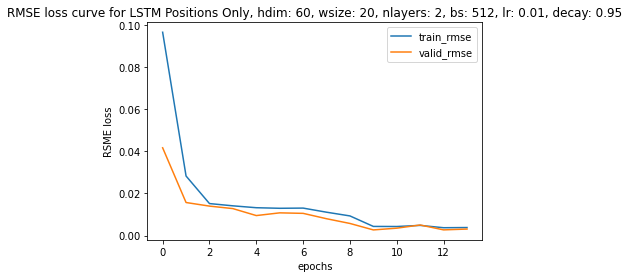

 88%|████████▊ | 308/352 [03:44<01:36,  2.20s/it]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481, 0.0037, 0.00379, 0.00363]
0.00221
Epoch 15 | T: 4.94 | Train RMSE: 0.00363 | Valid RMSE: 0.00221


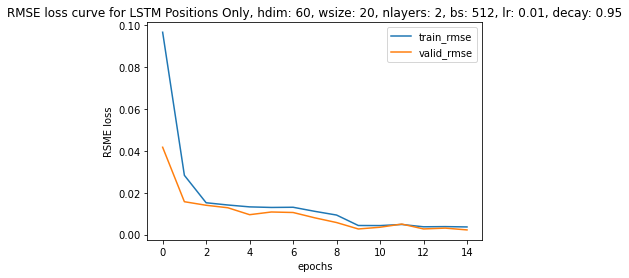

 88%|████████▊ | 308/352 [03:30<00:24,  1.76it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481, 0.0037, 0.00379, 0.00363, 0.00349]
0.0031
Epoch 16 | T: 4.99 | Train RMSE: 0.00349 | Valid RMSE: 0.00310


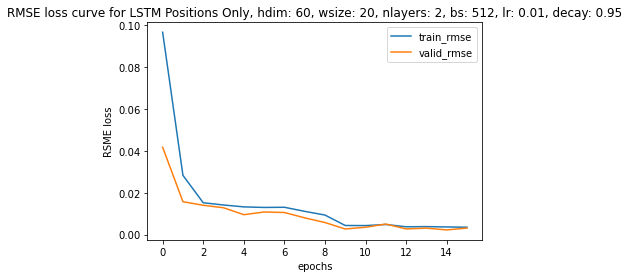

 88%|████████▊ | 308/352 [03:25<00:24,  1.82it/s]


100%|██████████| 352/352 [04:12<00:00,  1.39it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481, 0.0037, 0.00379, 0.00363, 0.00349, 0.00297]
0.00374
Epoch 17 | T: 4.95 | Train RMSE: 0.00297 | Valid RMSE: 0.00374


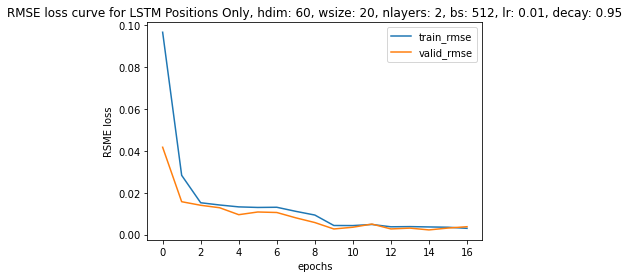

 88%|████████▊ | 308/352 [03:29<00:23,  1.89it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481, 0.0037, 0.00379, 0.00363, 0.00349, 0.00297, 0.00325]
0.00669
Epoch 18 | T: 4.95 | Train RMSE: 0.00325 | Valid RMSE: 0.00669


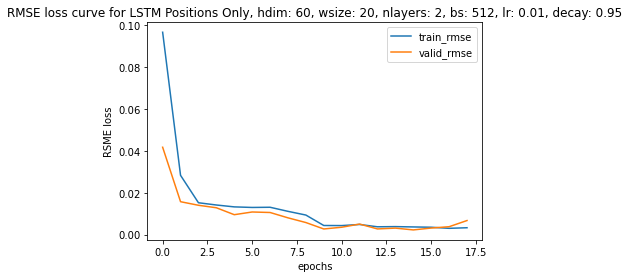

 88%|████████▊ | 308/352 [03:31<00:26,  1.67it/s]


100%|██████████| 352/352 [04:16<00:00,  1.37it/s]


[0.09661, 0.02828, 0.01518, 0.01411, 0.01321, 0.01294, 0.01303, 0.01108, 0.00931, 0.00432, 0.00428, 0.00481, 0.0037, 0.00379, 0.00363, 0.00349, 0.00297, 0.00325, 0.00301]


  2%|▏         | 18/1000 [1:33:45<85:14:53, 312.52s/it]

0.0028


In [105]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    print(train_rmse)
    
    model.eval()
    val_rmse = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)
    print(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
        torch.save(best_model.state_dict(), f'LSTMPositionsOnly_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')    
        break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for LSTM Positions Only, hdim: {hidden_dim}, wsize: {window_size}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'LSTMPositionsOnly_loss_curve_v1_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    

# Evaluation and Submission

In [106]:
torch.save(best_model.state_dict(), f'Finished_LstmPositionsOnly_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.pt')

In [108]:
model.load_state_dict(torch.load('Finished_LstmPositionsOnly_hdim_60_wsize_20_interval_1_nlayers_2_bs_512_lr_0.01_decay_0.95.pt'))
best_model = model

In [109]:
best_model

MyLSTM(
  (lstm): LSTM(2, 60, num_layers=2, batch_first=True)
  (fc): Linear(in_features=60, out_features=2, bias=True)
)

In [110]:
test_path = "./val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = test_sample['p_in']
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))

        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        #print(inp)
        # post-processing for LSTM
        predictions = [[]]
        inp_data = inp[0][-1]
        #print(inp_data.size())
        for i in range(30):
#             preds = best_model(inp_data.reshape(1, 1, 4))
            preds = best_model(inp_data.reshape(1, 1, 2))
            predictions[0].append(preds[0].cpu().data.numpy()[0, :2])
            #print(preds)
            inp_data = preds[0]
            
#         print(inp[0][-1])
#         preds = best_model(inp)#.cpu().data.numpy()
#         print(preds)
#         print(inp.shape)
#         print(preds[0].shape)

        predictions = np.array(predictions)
        #print(predictions.shape)

        # De-Normalization ! 
#         predictions = predictions * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(predictions)

In [111]:
test_pkl_list[0]
with open(test_pkl_list[0], 'rb') as f:
    test_sample = pickle.load(f)
    pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
    inp_scene = test_sample['p_in'][pred_id]
    print(inp_scene)

[[1697.71948242  320.87506104]
 [1698.5793457   321.80343628]
 [1699.5020752   322.73504639]
 [1700.39123535  323.5793457 ]
 [1701.33813477  324.42001343]
 [1702.20678711  325.3548584 ]
 [1702.95654297  325.91177368]
 [1703.99707031  327.12820435]
 [1704.39428711  326.98983765]
 [1705.8359375   328.68676758]
 [1706.51916504  329.17059326]
 [1706.89245605  329.39675903]
 [1708.3371582   330.92562866]
 [1709.33251953  332.10107422]
 [1709.64978027  332.0269165 ]
 [1710.62915039  332.87539673]
 [1712.06347656  334.58288574]
 [1712.99511719  335.45144653]
 [1713.8626709   336.29873657]]


In [112]:
print(test_preds[0].shape)
print(test_preds[0])

(1, 30, 2)
[[[0.9846257  0.92404926]
  [0.9874646  0.92861974]
  [0.9903269  0.9326848 ]
  [0.9932119  0.9363054 ]
  [0.99611974 0.9395338 ]
  [0.99905044 0.94241506]
  [1.0020043  0.94498837]
  [1.0049812  0.94728804]
  [1.0079813  0.94934404]
  [1.0110044  0.95118296]
  [1.0140501  0.9528283 ]
  [1.0171179  0.9543009 ]
  [1.0202068  0.9556195 ]
  [1.023316   0.95680064]
  [1.0264443  0.9578593 ]
  [1.0295899  0.9588088 ]
  [1.0327512  0.9596612 ]
  [1.0359261  0.9604274 ]
  [1.0391126  0.96111715]
  [1.0423081  0.96173936]
  [1.0455102  0.9623019 ]
  [1.0487162  0.9628121 ]
  [1.0519232  0.96327645]
  [1.0551281  0.9637007 ]
  [1.0583277  0.96409017]
  [1.0615189  0.96444964]
  [1.0646982  0.96478343]
  [1.0678624  0.96509516]
  [1.0710081  0.9653884 ]
  [1.0741318  0.9656661 ]]]


# Generate Submission File

### Steps to create submission file 
Run the below cells. The last cell will generate a submission file "test_submission.csv" that you can submit to Kaggle.

In [84]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [85]:
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,0.976786,0.915543,0.971943,0.912038,0.967277,0.908406,0.962781,0.904662,0.958452,...,0.901860,0.819629,0.900560,0.816497,0.899356,0.813475,0.898242,0.810565,0.897214,0.807768
1,10015,0.961604,0.917063,0.957335,0.912769,0.953215,0.908410,0.949243,0.903998,0.945420,...,0.897350,0.814081,0.896346,0.811037,0.895424,0.808119,0.894580,0.805325,0.893809,0.802657
2,10019,0.954430,0.939029,0.950283,0.933909,0.946270,0.928742,0.942397,0.923535,0.938663,...,0.893273,0.818932,0.892446,0.815427,0.891701,0.812072,0.891033,0.808869,0.890436,0.805817
3,10028,0.994690,0.995470,0.989478,0.990827,0.984367,0.986075,0.979358,0.981221,0.974454,...,0.902274,0.862937,0.900486,0.857885,0.898839,0.852943,0.897328,0.848123,0.895947,0.843432
4,1003,0.984294,0.967521,0.979349,0.962966,0.974525,0.958309,0.969822,0.953558,0.965243,...,0.901327,0.843718,0.899827,0.839376,0.898445,0.835162,0.897177,0.831080,0.896016,0.827135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,0.939520,0.982275,0.934902,0.976362,0.930421,0.970373,0.926089,0.964314,0.921912,...,0.877585,0.832121,0.877326,0.827333,0.877169,0.822744,0.877104,0.818361,0.877120,0.814187
3196,99,0.960192,0.968128,0.955673,0.962756,0.951275,0.957314,0.947005,0.951809,0.942867,...,0.891169,0.833360,0.890269,0.829049,0.889472,0.824902,0.888769,0.820921,0.888155,0.817109
3197,9905,0.990232,0.941584,0.985045,0.937923,0.980020,0.934116,0.975153,0.930179,0.970439,...,0.905301,0.835139,0.903697,0.831369,0.902206,0.827709,0.900823,0.824163,0.899543,0.820736
3198,9910,0.911707,0.969850,0.907389,0.963538,0.903257,0.957153,0.899323,0.950702,0.895597,...,0.868193,0.816197,0.868691,0.811783,0.869254,0.807606,0.869869,0.803666,0.870525,0.799965


In [79]:
# Save for later use
# predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
# sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
# sub_df.to_csv(f'test_submission_LSTMNoPositions_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [80]:
# Convert to float
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv(f'test_submission_LSTMPositionsOnly_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [81]:
sub_df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1705.090779,335.069659,1696.637611,333.786950,1688.491589,332.457383,1680.643557,331.087177,1673.086231,...,1574.299116,299.967013,1572.029546,298.820663,1569.927179,297.714647,1567.983379,296.649663,1566.189510,295.626192
1,10015,722.218082,1224.332615,719.011912,1218.600617,715.917567,1212.781563,712.934781,1206.891130,710.063463,...,673.960243,1086.846787,673.205929,1082.782856,672.513661,1078.886033,671.879724,1075.156558,671.300491,1071.594033
2,10019,571.243410,1238.014554,568.761253,1231.265085,566.359970,1224.452356,564.041344,1217.588235,561.806981,...,534.639741,1079.679029,534.144901,1075.057815,533.699291,1070.635573,533.299523,1066.412774,532.941994,1062.388789
3,10028,1681.775036,313.666131,1672.963619,312.202939,1664.321911,310.705752,1655.852934,309.176394,1647.561526,...,1525.523485,271.905832,1522.500585,270.313764,1519.715921,268.756855,1517.160626,267.237976,1514.825527,265.759796
4,1003,2113.205853,675.085549,2102.589098,671.907234,2092.230836,668.657678,2082.134009,665.342703,2072.303097,...,1935.081743,588.702294,1931.860694,585.672785,1928.894554,582.731903,1926.171296,579.883722,1923.678761,577.131570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,254.905848,800.857956,253.652886,796.036533,252.437361,791.153830,251.261812,786.213443,250.128536,...,238.102142,678.435427,238.031682,674.531646,237.989150,670.790808,237.971523,667.217189,237.975906,663.813948
3196,99,585.010895,1148.220495,582.257274,1141.848427,579.578027,1135.394426,576.976203,1128.865986,574.455144,...,542.957847,988.382084,542.409382,983.270106,541.923379,978.350978,541.495443,973.629435,541.121253,969.108446
3197,9905,1746.293351,442.221692,1737.146755,440.501981,1728.285228,438.713993,1719.700992,436.865006,1711.388055,...,1596.515215,392.229020,1593.687229,390.458192,1591.058014,388.739236,1588.619265,387.074113,1586.362363,385.464557
3198,9910,571.885846,1280.842058,569.177260,1272.505489,566.585736,1264.073436,564.118005,1255.553534,561.780385,...,544.590577,1077.918210,544.903142,1072.088476,545.256348,1066.571722,545.642269,1061.369602,546.053427,1056.481250


In [ ]:
# Ensemble Method 